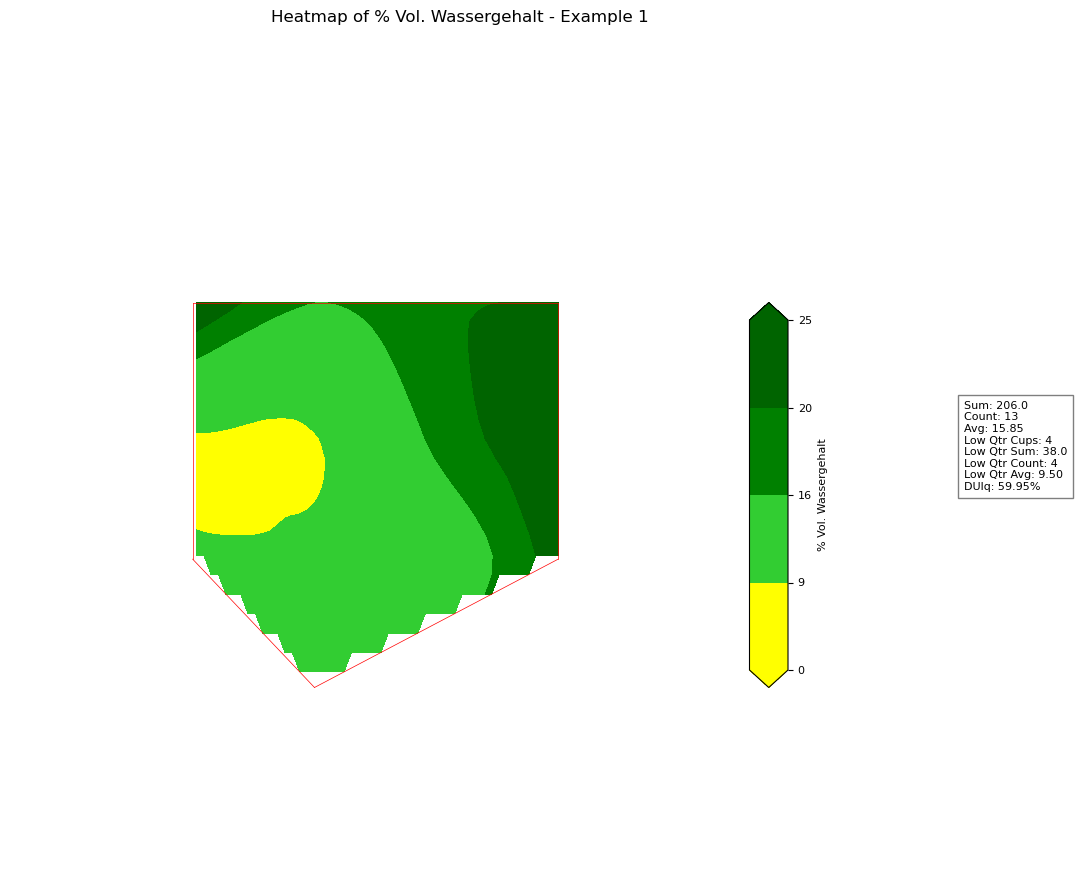

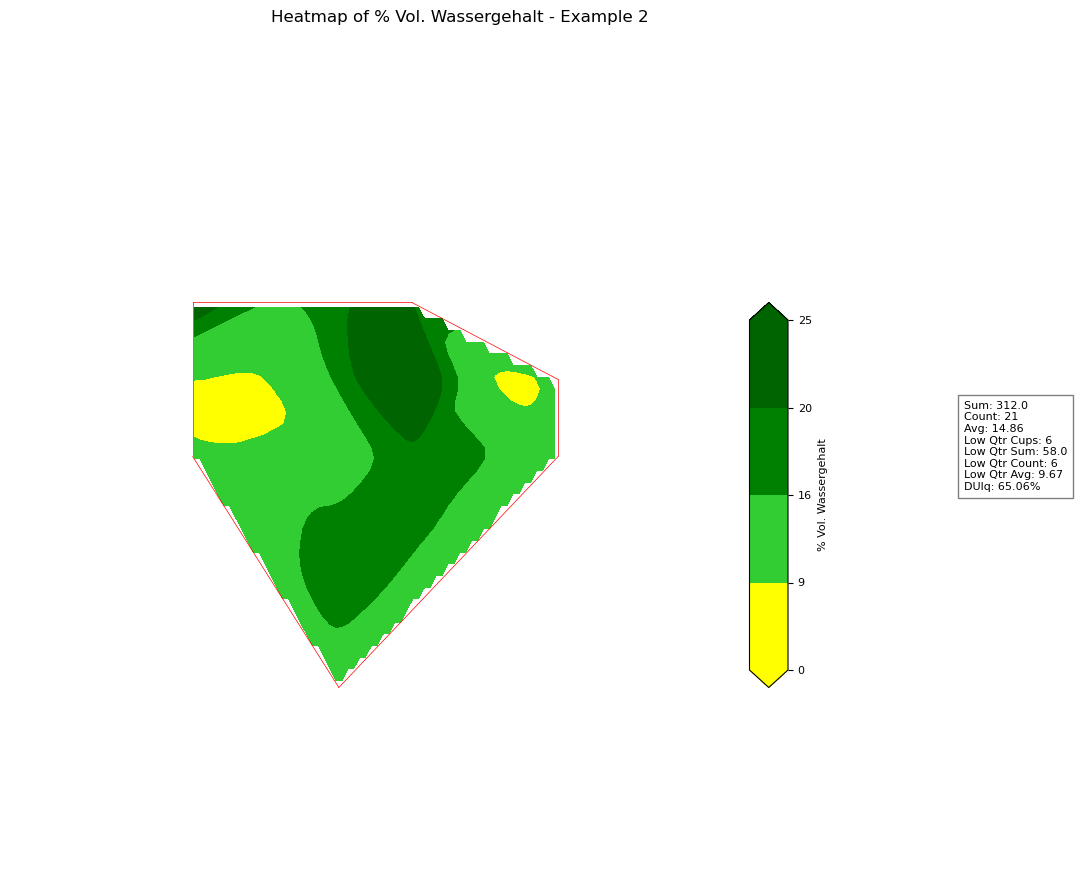

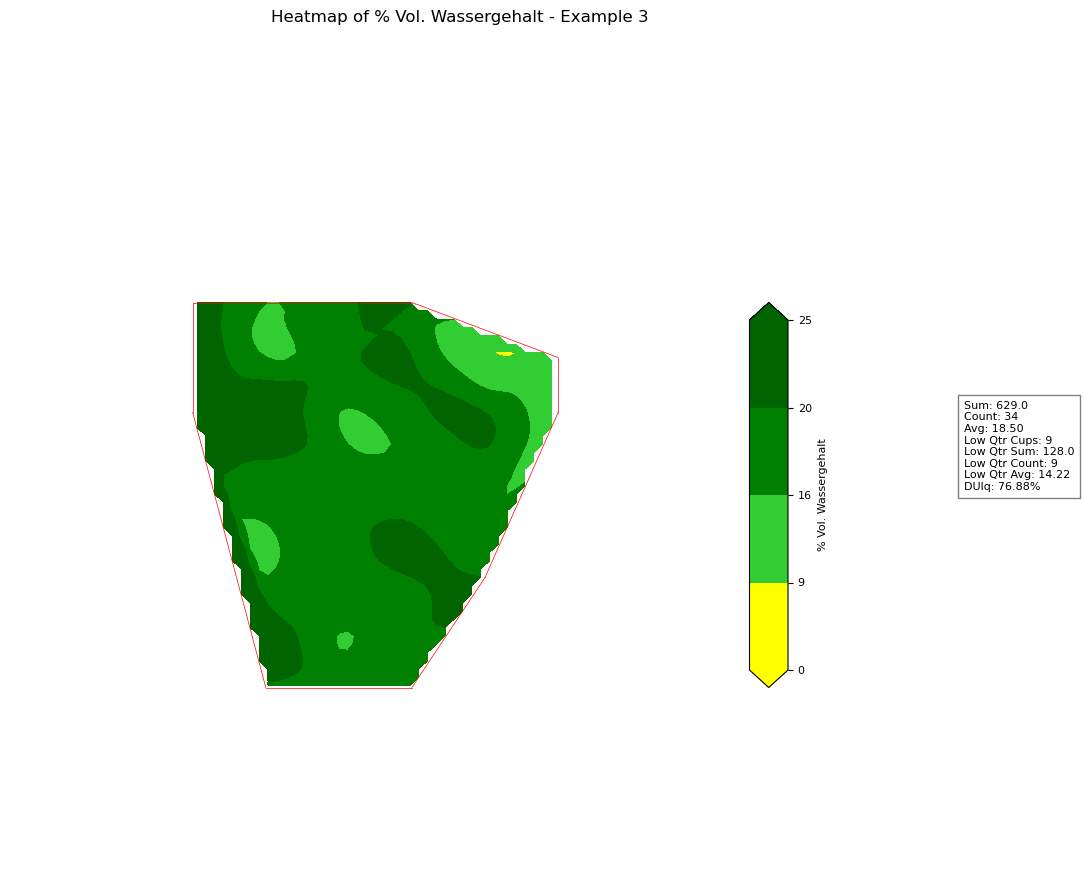

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy.spatial import ConvexHull

def read_excel_data(file_path, sheet_name):
    # Read the specified range from the Excel file (B6:P20)
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    messwerte_data = df.iloc[5:20, 1:16]
    # Ensure all values are numeric, coercing errors to NaN
    messwerte_data = messwerte_data.apply(pd.to_numeric, errors='coerce')
    return messwerte_data

def calculate_summary_statistics(data):
    # Flatten the data and remove NaN values
    values = data.values.flatten()
    values = values[~np.isnan(values)]
    
    summary = {
        'sum_all_boxes': np.sum(values),
        'count_boxes_with_data': len(values),
        'average_all_samples': np.mean(values),
        'no_of_cups_lowest_quarter': np.sum(values <= np.percentile(values, 25)),
        'sum_values_lowest_quarter': np.sum(values[values <= np.percentile(values, 25)]),
        'count_boxes_lowest_quarter': np.sum(values <= np.percentile(values, 25)),
        'average_lowest_quarter': np.mean(values[values <= np.percentile(values, 25)]),
        'distribution_uniformity': (np.mean(values[values <= np.percentile(values, 25)]) / np.mean(values)) * 100
    }
    
    return summary

def plot_heatmap(data, title, summary):
    # Flatten the data and create coordinate points
    values = data.values.flatten()
    num_values = len(values)
    grid_size = data.shape

    points = []
    values_list = []
    for i, value in enumerate(values):
        x = i % grid_size[1]
        y = i // grid_size[1]
        if not np.isnan(value):  # Only include non-NaN values
            points.append((x, y))
            values_list.append(value)

    # Create grid for interpolation
    grid_x, grid_y = np.mgrid[0:grid_size[1]:100j, 0:grid_size[0]:100j]

    # Interpolate values
    grid_z = griddata(points, values_list, (grid_x, grid_y), method='cubic')

    # Define the color levels and colormap
    levels = [0, 9, 16, 20, 25]
    colors = ['yellow', 'limegreen', 'green', 'darkgreen']
    cmap = ListedColormap(colors)
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

    # Generate heatmap using contourf with absolute color transitions
    fig, ax = plt.subplots(figsize=(12, 10))
    contourf = ax.contourf(grid_x, grid_y, grid_z, levels=levels, cmap=cmap, norm=norm, extend='both')

    # Adjust the colorbar size and position
    cbar = fig.colorbar(contourf, ticks=levels, pad=0.01, shrink=0.5, aspect=10)
    cbar.ax.set_yticklabels([str(level) for level in levels])
    cbar.set_label('% Vol. Wassergehalt', fontsize=8)
    cbar.ax.tick_params(labelsize=8)

    # Add a red border around the outermost area using ConvexHull for smooth border
    if points:
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            ax.plot([points[simplex[0]][0], points[simplex[1]][0]],
                    [points[simplex[0]][1], points[simplex[1]][1]], 'r-', linewidth=0.5)

    # Calculate the bounding box of the heatmap
    non_nan_points = np.array(points)
    x_min, y_min = non_nan_points.min(axis=0)
    x_max, y_max = non_nan_points.max(axis=0)

    # Center the plot
    x_center = (x_min + x_max) / 2
    y_center = (y_min + y_max) / 2
    x_range = x_max - x_min
    y_range = y_max - y_min

    x_limits = [x_center - x_range, x_center + x_range]
    y_limits = [y_center - y_range, y_center + y_range]

    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)
    ax.invert_yaxis()  # Invert y-axis to match the data orientation

    # Remove axes for a cleaner look
    ax.axis('off')

    # Display summary statistics outside the plot area
    summary_text = '\n'.join([
        f"Sum: {summary['sum_all_boxes']}",
        f"Count: {summary['count_boxes_with_data']}",
        f"Avg: {summary['average_all_samples']:.2f}",
        f"Low Qtr Cups: {summary['no_of_cups_lowest_quarter']}",
        f"Low Qtr Sum: {summary['sum_values_lowest_quarter']}",
        f"Low Qtr Count: {summary['count_boxes_lowest_quarter']}",
        f"Low Qtr Avg: {summary['average_lowest_quarter']:.2f}",
        f"DUlq: {summary['distribution_uniformity']:.2f}%"
    ])
    fig.text(0.92, 0.5, summary_text, fontsize=8, bbox=dict(facecolor='white', alpha=0.5), ha='left')

    # Display the plot
    fig.suptitle(title)
    plt.subplots_adjust(right=0.85)  # Adjust to make room for the summary text
    plt.show()

# File path to the Excel data
file_path = 'Distribution_Uniformity.xlsx'

# Read, calculate summary statistics, and plot data for Example 1, Example 2, and Example 3
for sheet_name in ['Example 1', 'Example 2', 'Example 3']:
    data = read_excel_data(file_path, sheet_name)
    summary = calculate_summary_statistics(data)
    plot_heatmap(data, f"Heatmap of % Vol. Wassergehalt - {sheet_name}", summary)
